In [2]:
from scipy import stats

class City:
    commuters_percentage = 0.1
    st_dev = 30

    def __init__(self, name, population,mean_leave):
        self.name = name
        self.population = population
        self.mean_leave = mean_leave

    def onramp(time):
        #Calculate the z-score for the normal dist. at the current time and the last time
        z_now = (time-self.mean_leave) / st_dev
        z_last = ((time-1)-self.mean_leave) / st_dev
        #Calculate the probability of a car entering the highway in the last minute
        cdf_now = stats.norm.cdf(z_now)
        cdf_last = stats.norm.cdf(z_last)
        probability = cdf_now - cdf_last
        #Calculate the expected number of cars entering in the last minute
        cars_coming_on = probability*commuters_percentage*self.population
    
class Road:
    free_flow_speed = 110/60 #110 is the free flow speed in km/h, so 110/60 is km/min
    jam_density = 135
    def __init__(self, length, lanes,onramp_city):
        self.length = length
        self.lanes=lanes
        self.city = onramp_city
        self.vehicle_count = 0
        
    def outflow(self):
        density = self.vehicle_count / (self.lanes * self.length)
        outflow = free_flow_speed*density*(1 - (density/jam_density))
        return outflow
    
    def update(self,time,road_inflow):
        onramp_inflow = self.city.onramp(time)
        outflow = self.outflow()
        self.vehicles = self.vehicles + onramp_inflow + road_inflow - outflow

In [7]:
total = 0
stdev = 100
time_values = [s/1000 for s in range(-10000,10000)]
percentages = []
for inc in range(len(time_values)-1):
    cdf_1 = stats.norm.cdf(time_values[inc])
    cdf_2 = stats.norm.cdf(time_values[inc+1])
    diff = cdf_2 - cdf_1
    percentages.append(diff)
print(sum(percentages))

1.0


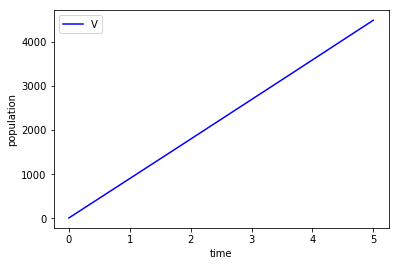

In [6]:
# odeint performed on SIR model
import numpy as np
import scipy.integrate as integrate 
import matplotlib.pyplot as plt
from pylab import * 

#Note: t = 0 is 5:30 am

#Setup Our 4 cities
cities = [
    City(name="Hamilton",population=747545,mean_leave=100),
    City(name="Burlington",population=183314,mean_leave=115),
    City(name="Oakville",population=193832,mean_leave=135),
    City(name="Mississauga",population=721599,mean_leave=155)
]

# constants 
s=110  #speed
d=100  #length of highway (one part)
l=4    #Number of lanes of stretch of highway
j=135    #jam density
run_time = 3

def intialize(): 
    global v,vresult
    v = 100.0 
    vresult = [v]
    
def observe(): 
    global v,vresult
    vresult.append(v)
    
def update(): 
    global v,vresult 
    nextv = 
    v = nextv

intialize()

for t in range(run_time):
    update()
    observe()
    
plot(vresult, color='blue') 
title("$s=$"+str(s)+ ", $d=$"+str(d)+", $l=$"+str(l)+", $j=$"+str(j)+ ", $ v_O=$"+str(vresult[0]))
show()